# 52: Try multithreading for downloads

In [1]:
from herbie.archive import Herbie
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import logging
log = logging.getLogger(__name__)

from herbie.tools import fast_Herbie, fast_Herbie_download, fast_Herbie_xarray

from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed, wait

🥳 Herbie loaded your custom templates.


In [2]:
fxx = [0,3]

# COAMPS
#DATES = pd.date_range('2017-08-01', periods=3, freq='12H')
#a = fast_Herbie(DATES, fxx=fxx, model='coamps', nest=3, project="hfradarCB_real-narwhal_v0.4.15s")

# HRRR
DATES = pd.date_range('2022-04-01', periods=3, freq='12H')
a = fast_Herbie(DATES, fxx=fxx)

In [3]:
ds = fast_Herbie_xarray(DATES, fxx=fxx, searchString='(?:U|V)GRD:10 m')

In [4]:
ds

<xarray.Dataset>
Dimensions:              (t: 3, f: 2, y: 1059, x: 1799)
Coordinates:
    time                 (t) datetime64[ns] 2022-04-01 ... 2022-04-02
    step                 (f) timedelta64[ns] 00:00:00 03:00:00
    heightAboveGround    float64 10.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           (f, t) datetime64[ns] 2022-04-01 ... 2022-04-02T03:0...
Dimensions without coordinates: t, f, y, x
Data variables:
    u10                  (f, t, y, x) float32 -4.994 -4.994 ... -8.387 -8.762
    v10                  (f, t, y, x) float32 -5.197 -5.197 ... 2.074 2.136
    gribfile_projection  (f, t) object None None None None None None

In [5]:
a[0].xarray('(?:U|V)GRD:10 m')

<xarray.Dataset>
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 2022-04-01
    step                 timedelta64[ns] 00:00:00
    heightAboveGround    float64 10.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           datetime64[ns] 2022-04-01
Dimensions without coordinates: y, x
Data variables:
    u10                  (y, x) float32 ...
    v10                  (y, x) float32 ...
    gribfile_projection  object None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             /p/cwfs/blaylock/data/hrrr/20220401/hrrr.t00z.wr...
    local_grib:              /p/cwfs/blaylock/data/hrrr/20220401/hrrr.t00z.wr...
    searchString:            (?:U|V)GRD:10 m

In [92]:
a[0].grib_source

'local'

In [4]:
a[0].verbose

False

In [7]:
fast_Herbie_download(DATES, fxx=fxx)

{'passed': [[HRRR] model [sfc] product run at 2022-Apr-01 00:00 UTC F00,
  [HRRR] model [sfc] product run at 2022-Apr-01 00:00 UTC F03,
  [HRRR] model [sfc] product run at 2022-Apr-01 12:00 UTC F00,
  [HRRR] model [sfc] product run at 2022-Apr-01 12:00 UTC F03,
  [HRRR] model [sfc] product run at 2022-Apr-02 00:00 UTC F00,
  [HRRR] model [sfc] product run at 2022-Apr-02 00:00 UTC F03],
 'failed': []}

In [ ]:
def fast_Herbie_download(
    DATES, *, searchString=None, fxx=[0], max_threads=50, **kwargs
):
    """
    Use multithreading to download many Herbie objects
    """

    kwargs.setdefault("verbose", False)

    Hs = fast_Herbie(DATES, fxx=fxx, max_threads=max_threads, **kwargs)

    passed = [H for H in Hs if H.grib is not None]
    failed = [H for H in Hs if H.grib is None]

    ###########################
    # Multithread the downloads
    tasks = len(DATES) * len(fxx)
    threads = min(tasks, max_threads)
    log.info(f"🧵 Working on {tasks} tasks with {threads} threads.")


    with ThreadPoolExecutor(max_threads) as exe:
        futures = [exe.submit(H.download, searchString) for H in passed]

        # Return list of Herbie objects in order completed
        _ = [future.result() for future in as_completed(futures)]

    if len(failed):
        log.warning(
            f"Herbie only download {len(passed)}/{len(Hs)} files. ({len(failed)} had no GRIB2 file)."
        )

    return dict(passed=passed, failed=failed)

In [5]:
def fast_Herbie_xarray(
    DATES, *, searchString=None, fxx=[0], max_threads=20, **kwargs
):
    """
    Use multithreading to download many Herbie objects
    """

    kwargs.setdefault("verbose", False)

    Hs = fast_Herbie(DATES, fxx=fxx, max_threads=max_threads, **kwargs)

    passed = [H for H in Hs if H.grib is not None]
    failed = [H for H in Hs if H.grib is None]

    ###########################
    # Multithread the downloads
    tasks = len(DATES) * len(fxx)
    threads = min(tasks, max_threads)
    log.info(f"🧵 Working on {tasks} tasks with {threads} threads.")


    with ThreadPoolExecutor(max_threads) as exe:
        futures = [exe.submit(H.xarray, searchString) for H in passed]

        # Return list of Herbie objects in order completed
        ds_list = [future.result() for future in as_completed(futures)]

    # Sort the DataSets, first by lead time (step), then by run time (time)
    ds_list.sort(key=lambda ds: ds.step.item())
    ds_list.sort(key=lambda ds: ds.time.item())

    # Reshape list with dimensions (len(DATES), len(fxx))
    ds_list = [ ds_list[x:x+len(fxx)] for x in range(0, len(ds_list), len(fxx)) ] 

    # Concat DataSets
    ds = xr.combine_nested(ds_list, concat_dim=['t', 'f']).squeeze()

    if len(failed):
        log.warning(
            f"Herbie only retrieved {len(passed)}/{len(Hs)} files. ({len(failed)} had no GRIB2 file)."
        )

    return ds

In [24]:
%%time
DATES = pd.date_range('2022-02-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie(DATES=DATES, fxx=fxx, max_threads=1)

CPU times: user 888 ms, sys: 90.6 ms, total: 978 ms
Wall time: 16.4 s


In [25]:
%%time
DATES = pd.date_range('2022-02-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie(DATES=DATES, fxx=fxx, max_threads=2)

CPU times: user 850 ms, sys: 59.4 ms, total: 909 ms
Wall time: 8.02 s


In [34]:
%%timeit
DATES = pd.date_range('2022-02-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie(DATES=DATES, fxx=fxx, max_threads=5)

3.28 s ± 230 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%%timeit
DATES = pd.date_range('2022-02-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie(DATES=DATES, fxx=fxx, max_threads=10)

1.7 s ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%%timeit
DATES = pd.date_range('2022-02-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie(DATES=DATES, fxx=fxx, max_threads=50)

509 ms ± 9.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%time
DATES = pd.date_range('2022-01-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie_download(DATES=DATES, fxx=fxx, max_threads=1, searchString='TMP:2 m', overwrite=True)

CPU times: user 2.27 s, sys: 5.79 s, total: 8.06 s
Wall time: 1min 17s


In [21]:
%%time
DATES = pd.date_range('2022-01-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie_download(DATES=DATES, fxx=fxx, max_threads=2, searchString='TMP:2 m', overwrite=True)

CPU times: user 2.29 s, sys: 5.57 s, total: 7.86 s
Wall time: 36.2 s


In [22]:
%%time
DATES = pd.date_range('2022-01-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie_download(DATES=DATES, fxx=fxx, max_threads=5, searchString='TMP:2 m', overwrite=True)

CPU times: user 2.5 s, sys: 6.23 s, total: 8.73 s
Wall time: 28.5 s


In [23]:
%%time
DATES = pd.date_range('2022-01-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie_download(DATES=DATES, fxx=fxx, max_threads=50, searchString='TMP:2 m', overwrite=True)

CPU times: user 2.7 s, sys: 5.94 s, total: 8.64 s
Wall time: 23.7 s


In [12]:
%%time
DATES = pd.date_range('2022-01-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie_xarray(DATES=DATES, fxx=fxx, max_threads=10, searchString='TMP:2 m')

CPU times: user 36.4 s, sys: 7.26 s, total: 43.6 s
Wall time: 36.6 s


In [13]:
%%time
DATES = pd.date_range('2022-01-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie_xarray(DATES=DATES, fxx=fxx, max_threads=5, searchString='TMP:2 m')

CPU times: user 36 s, sys: 8.4 s, total: 44.4 s
Wall time: 39.3 s


In [16]:
len(DATES)*len(fxx)

48

In [17]:
%%time
DATES = pd.date_range('2022-01-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie_xarray(DATES=DATES, fxx=fxx, max_threads=1, searchString='TMP:2 m')

CPU times: user 35.9 s, sys: 8.63 s, total: 44.5 s
Wall time: 1min 45s


In [14]:
%%time
DATES = pd.date_range('2022-01-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie_xarray(DATES=DATES, fxx=fxx, max_threads=2, searchString='TMP:2 m')

CPU times: user 35.6 s, sys: 8.61 s, total: 44.2 s
Wall time: 55.3 s


In [18]:
%%time
DATES = pd.date_range('2022-01-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie_xarray(DATES=DATES, fxx=fxx, max_threads=10, searchString='TMP:2 m')

CPU times: user 36.8 s, sys: 10.4 s, total: 47.1 s
Wall time: 39.7 s


In [15]:
%%time
DATES = pd.date_range('2022-01-01', periods=4, freq='1H')
fxx = range(0,12)
ds = fast_Herbie_xarray(DATES=DATES, fxx=fxx, max_threads=50, searchString='TMP:2 m')

CPU times: user 36.2 s, sys: 9.85 s, total: 46 s
Wall time: 37.8 s


In [87]:
%%time
ds = fast_Herbie_xarray(DATES, fxx=fxx, max_threads=50, overwrite=True, searchString="TMP:2 m")

CPU times: user 4.43 s, sys: 276 ms, total: 4.71 s
Wall time: 4.71 s


In [85]:
ds.isel(t=0).time

<xarray.DataArray 'time' ()>
array('2022-04-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time               datetime64[ns] 2022-04-01
    heightAboveGround  float64 2.0

In [13]:
%%time
b = fast_Herbie_xarray(DATES, fxx=fxx, searchString="TMP:2 m")

CPU times: user 4.16 s, sys: 376 ms, total: 4.53 s
Wall time: 4.3 s


In [16]:
len(b[0])

6

In [52]:
ds = b[0]

In [24]:
b[0].sort(key=lambda ds: ds.step.item())
b[0].sort(key=lambda ds: ds.time.item())

In [53]:
ds.reshape

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:
# Put the items in a grid
[
    [ds[0], ds[1]],
    [ds[2], ds[3]],
    [ds[4], ds[5]],
]

In [67]:
len(DATES)

3

In [73]:
# first, i create some data
l = ds
# now I reshape in to slices of 4 items
xi = len(fxx)
x = [ l[x:x+xi] for x in range(0, len(l), xi) ] 
x


[[<xarray.Dataset>
  Dimensions:              (y: 1059, x: 1799)
  Coordinates:
      time                 datetime64[ns] 2022-04-01
      step                 timedelta64[ns] 00:00:00
      heightAboveGround    float64 2.0
      latitude             (y, x) float64 ...
      longitude            (y, x) float64 ...
      valid_time           datetime64[ns] 2022-04-01
  Dimensions without coordinates: y, x
  Data variables:
      t2m                  (y, x) float32 ...
      gribfile_projection  object None
  Attributes:
      GRIB_edition:            2
      GRIB_centre:             kwbc
      GRIB_centreDescription:  US National Weather Service - NCEP 
      GRIB_subCentre:          0
      Conventions:             CF-1.7
      institution:             US National Weather Service - NCEP 
      model:                   hrrr
      product:                 sfc
      description:             High-Resolution Rapid Refresh - CONUS
      remote_grib:             /p/cwfs/blaylock/data/hrrr/202

In [72]:
# first, i create some data
l = [ i for i in range(20) ]
# now I reshape in to slices of 4 items
xi = 2
x = [ l[x:x+xi] for x in range(0, len(l), xi) ] 
x


[[0, 1],
 [2, 3],
 [4, 5],
 [6, 7],
 [8, 9],
 [10, 11],
 [12, 13],
 [14, 15],
 [16, 17],
 [18, 19]]

In [49]:
[pd.to_datetime(i.time.item()) for i in b[0]]

[Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-04-01 00:00:00'),
 Timestamp('2022-04-01 12:00:00'),
 Timestamp('2022-04-01 12:00:00'),
 Timestamp('2022-04-02 00:00:00'),
 Timestamp('2022-04-02 00:00:00')]

In [51]:
[pd.to_timedelta(i.step.item()) for i in b[0]]

[Timedelta('0 days 00:00:00'),
 Timedelta('0 days 03:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 03:00:00'),
 Timedelta('0 days 00:00:00'),
 Timedelta('0 days 03:00:00')]

In [77]:
xr.combine_nested(ds, concat_dim=['t', 'f']).squeeze()

<xarray.Dataset>
Dimensions:              (f: 6, y: 1059, x: 1799)
Coordinates:
    time                 (f) datetime64[ns] 2022-04-01 2022-04-01 ... 2022-04-02
    step                 (f) timedelta64[ns] 00:00:00 03:00:00 ... 03:00:00
    heightAboveGround    float64 2.0
    latitude             (y, x) float64 21.14 21.15 21.15 ... 47.86 47.85 47.84
    longitude            (y, x) float64 237.3 237.3 237.3 ... 299.0 299.0 299.1
    valid_time           (f) datetime64[ns] 2022-04-01 ... 2022-04-02T03:00:00
Dimensions without coordinates: f, y, x
Data variables:
    t2m                  (f, y, x) float32 292.2 292.2 292.2 ... 272.7 272.8
    gribfile_projection  (f) object None None None None None None

In [48]:
%%time
b = fast_Herbie_download(a, threads=1, searchString="TMP:2 m", overwrite=True, verbose=False)

CPU times: user 20.9 ms, sys: 39.4 ms, total: 60.3 ms
Wall time: 3.52 s


In [43]:
len(b[0]), len(b[1])

(6, 0)

In [34]:
b[1]

[[HRRR] model [sfc] product run at 2017-Aug-01 00:00 UTC F00,
 [HRRR] model [sfc] product run at 2017-Aug-01 00:00 UTC F03]

In [37]:
b[1][0]

[HRRR] model [sfc] product run at 2017-Aug-01 00:00 UTC F00

In [38]:
b[1][0].SOURCES

{'aws': 'https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20170801/conus/hrrr.t00z.wrfsfcf00.grib2',
 'nomads': 'https://nomads.ncep.noaa.gov/pub/data/nccf/com/hrrr/prod/hrrr.20170801/conus/hrrr.t00z.wrfsfcf00.grib2',
 'google': 'https://storage.googleapis.com/high-resolution-rapid-refresh/hrrr.20170801/conus/hrrr.t00z.wrfsfcf00.grib2',
 'azure': 'https://noaahrrr.blob.core.windows.net/hrrr/hrrr.20170801/conus/hrrr.t00z.wrfsfcf00.grib2',
 'pando': 'https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20170801/hrrr.t00z.wrfsfcf00.grib2',
 'pando2': 'https://pando-rgw02.chpc.utah.edu/hrrr/sfc/20170801/hrrr.t00z.wrfsfcf00.grib2'}

In [ ]:
passed = [H.grib is not None for H in Hs]
failed = [H.grib is None for H in Hs]

In [12]:
a

[[COAMPS] model [sfc] product run at 2017-Aug-01 00:00 UTC F00,
 [COAMPS] model [sfc] product run at 2017-Aug-01 00:00 UTC F03,
 [COAMPS] model [sfc] product run at 2017-Aug-01 12:00 UTC F00,
 [COAMPS] model [sfc] product run at 2017-Aug-01 12:00 UTC F03,
 [COAMPS] model [sfc] product run at 2017-Aug-02 00:00 UTC F00,
 [COAMPS] model [sfc] product run at 2017-Aug-02 00:00 UTC F03]

In [4]:
a

[[COAMPS] model [sfc] product run at 2017-Aug-01 00:00 UTC F00,
 [COAMPS] model [sfc] product run at 2017-Aug-01 00:00 UTC F03,
 [COAMPS] model [sfc] product run at 2017-Aug-01 06:00 UTC F00,
 [COAMPS] model [sfc] product run at 2017-Aug-01 06:00 UTC F03,
 [COAMPS] model [sfc] product run at 2017-Aug-01 12:00 UTC F00,
 [COAMPS] model [sfc] product run at 2017-Aug-01 12:00 UTC F03,
 [COAMPS] model [sfc] product run at 2017-Aug-01 18:00 UTC F00,
 [COAMPS] model [sfc] product run at 2017-Aug-01 18:00 UTC F03,
 [COAMPS] model [sfc] product run at 2017-Aug-02 00:00 UTC F00,
 [COAMPS] model [sfc] product run at 2017-Aug-02 00:00 UTC F03,
 [COAMPS] model [sfc] product run at 2017-Aug-02 06:00 UTC F00,
 [COAMPS] model [sfc] product run at 2017-Aug-02 06:00 UTC F03,
 [COAMPS] model [sfc] product run at 2017-Aug-02 12:00 UTC F00,
 [COAMPS] model [sfc] product run at 2017-Aug-02 12:00 UTC F03,
 [COAMPS] model [sfc] product run at 2017-Aug-02 18:00 UTC F00,
 [COAMPS] model [sfc] product run at 201

In [2]:
DATES = pd.date_range('2022-01-01', periods=12, freq='6H')
fxx = [0,1,2]
a = bulk_download(DATES, "TMP:2 m", fxx=fxx)

👨🏻‍🔬 Check which requested files exists

🌧 Download requested data
🌉 Already have local copy --> /p/cwfs/blaylock/data/hrrr/20220101/hrrr.t00z.wrfsfcf00.grib2.subset_b7103ca278a75cad8f7d065acda0c2e80da0b7dc
🚛💨 Download Progress: [1/36 completed] >> Est. Time Remaining 0:00:12.419785  

🌉 Already have local copy --> /p/cwfs/blaylock/data/hrrr/20220101/hrrr.t00z.wrfsfcf01.grib2.subset_b7103ca278a75cad8f7d065acda0c2e80da0b7dc
🚛💨 Download Progress: [2/36 completed] >> Est. Time Remaining 0:00:12.710628  

🌉 Already have local copy --> /p/cwfs/blaylock/data/hrrr/20220101/hrrr.t00z.wrfsfcf02.grib2.subset_b7103ca278a75cad8f7d065acda0c2e80da0b7dc
🚛💨 Download Progress: [3/36 completed] >> Est. Time Remaining 0:00:12.144825  

🌉 Already have local copy --> /p/cwfs/blaylock/data/hrrr/20220101/hrrr.t06z.wrfsfcf00.grib2.subset_b7103ca278a75cad8f7d065acda0c2e80da0b7dc
🚛💨 Download Progress: [4/36 completed] >> Est. Time Remaining 0:00:11.713824  

🌉 Already have local copy --> /p/cwfs/blaylock/data/h

In [5]:
a

{'success': [[HRRR] model [sfc] product run at 2022-Jan-01 00:00 UTC F00,
  [HRRR] model [sfc] product run at 2022-Jan-01 00:00 UTC F01,
  [HRRR] model [sfc] product run at 2022-Jan-01 00:00 UTC F02,
  [HRRR] model [sfc] product run at 2022-Jan-01 06:00 UTC F00,
  [HRRR] model [sfc] product run at 2022-Jan-01 06:00 UTC F01,
  [HRRR] model [sfc] product run at 2022-Jan-01 06:00 UTC F02,
  [HRRR] model [sfc] product run at 2022-Jan-01 12:00 UTC F00,
  [HRRR] model [sfc] product run at 2022-Jan-01 12:00 UTC F01,
  [HRRR] model [sfc] product run at 2022-Jan-01 12:00 UTC F02,
  [HRRR] model [sfc] product run at 2022-Jan-01 18:00 UTC F00,
  [HRRR] model [sfc] product run at 2022-Jan-01 18:00 UTC F01,
  [HRRR] model [sfc] product run at 2022-Jan-01 18:00 UTC F02,
  [HRRR] model [sfc] product run at 2022-Jan-02 00:00 UTC F00,
  [HRRR] model [sfc] product run at 2022-Jan-02 00:00 UTC F01,
  [HRRR] model [sfc] product run at 2022-Jan-02 00:00 UTC F02,
  [HRRR] model [sfc] product run at 2022-Jan

In [77]:
def fast_Herbie(DATES, fxx=0, *, max_threads=20, **kwargs):
    """
    Create many Herbie objects with Multithreading

    Parameters
    ----------
    DATES : pandas-parsable datetime string or list of datetimes
    fxx : int or list of forecast lead times
    max_threads : int
        Maximum number of threads to use.
    kwargs :
        Remaining keywords for Herbie object
        (e.g., model, product, priority, verbose, etc.)
    """
    ################
    # Validate Input
    if isinstance(DATES, str):
        DATES = [pd.to_datetime(DATES)]

    if not isinstance(DATES, (list, pd.DatetimeIndex)):
        raise ValueError("DATES must be a pandas-parsable datetime string or a list.")

    if isinstance(fxx, int):
        fxx = [fxx]

    if not isinstance(fxx, (list, range)):
        raise ValueError("fxx must be an int, list, or range.")

    kwargs.setdefault('verbose', False)


    ################
    # Multithreading
    tasks = len(DATES) * len(fxx)
    threads = min(tasks, max_threads)
    log.info(f"🧵 Working on {tasks} tasks with {threads} threads.")

    with ThreadPoolExecutor(threads) as exe:
        futures = [
            exe.submit(Herbie, date=DATE, fxx=f, **kwargs)
            for DATE in DATES for f in fxx
        ]

        # Return list of Herbie objects in order completed
        H_list = [future.result() for future in as_completed(futures)]

        # Return list of Herbie objects in order submitted
        #futures, _ = wait(futures)
        #H_list = [future.result() for future in futures]

    log.info(f"Number of Herbie objects: {len(H_list)}")
    
    # Sort the list of Herbie objects by lead time then by date
    H_list.sort(key=lambda H: H.fxx)
    H_list.sort(key=lambda H: H.date)

    return H_list


In [46]:
len(DATES) * len(range(12))

144

In [54]:
%%timeit
np.minimum(3, 12)

876 ns ± 1.98 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [55]:
%%timeit
min(3, 12)

104 ns ± 0.129 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [27]:
type(DATES) == pd.DatetimeIndex

True

In [81]:
%%time
DATES = pd.date_range('2022-01-01', periods=12, freq='6H')
a = fast_Herbie(DATES, model='gfs', fxx=range(0,12,6))

CPU times: user 441 ms, sys: 38.6 ms, total: 480 ms
Wall time: 678 ms


In [82]:
a

[[GFS] model [pgrb2.0p25] product run at 2022-Jan-01 00:00 UTC F00,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-01 00:00 UTC F06,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-01 06:00 UTC F00,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-01 06:00 UTC F06,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-01 12:00 UTC F00,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-01 12:00 UTC F06,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-01 18:00 UTC F00,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-01 18:00 UTC F06,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-02 00:00 UTC F00,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-02 00:00 UTC F06,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-02 06:00 UTC F00,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-02 06:00 UTC F06,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-02 12:00 UTC F00,
 [GFS] model [pgrb2.0p25] product run at 2022-Jan-02 12:00 UTC F06,
 [GFS] model [pgrb2.0p25] product run at 2022-Ja

In [73]:
%%time
DATES = pd.date_range('2021-01-01', periods=12, freq='3H')
a = start_your_engines(DATES, fxx=range(12), max_threads=10)

🧵 Working on 144 tasks with 10 threads.
Number of Herbie objects: 144
CPU times: user 2.23 s, sys: 230 ms, total: 2.45 s
Wall time: 4.56 s


🧵 Working on 144 tasks with 1 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 6 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 11 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 16 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 21 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 26 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 31 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 36 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 41 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 46 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 51 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 56 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 61 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks with 66 threads.
Number of Herbie objects: 144
🧵 Working on 144 tasks

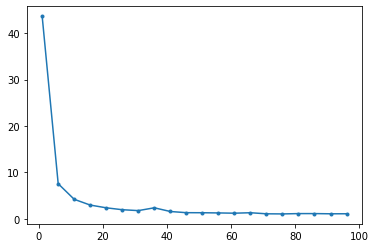

In [69]:
threads = range(1,100,5)
dt = []
for t in threads:
    timer = pd.Timestamp('now')

    DATES = pd.date_range('2021-01-01', periods=12, freq='3H')
    a = start_your_engines(DATES, fxx=range(12), max_threads=t)

    dt.append((pd.Timestamp('now')-timer).total_seconds())
plt.plot(threads, dt, marker='.')

In [75]:
dt

[43.613604,
 7.576259,
 4.222154,
 2.982228,
 2.392096,
 1.982606,
 1.790337,
 2.395526,
 1.598835,
 1.344467,
 1.332231,
 1.290784,
 1.232739,
 1.332033,
 1.102591,
 1.078482,
 1.147241,
 1.148874,
 1.105136,
 1.111259]

In [70]:
a

[[HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F00,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F01,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F02,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F03,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F04,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F05,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F06,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F07,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F08,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F09,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F10,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F11,
 [HRRR] model [sfc] product run at 2021-Jan-01 03:00 UTC F00,
 [HRRR] model [sfc] product run at 2021-Jan-01 03:00 UTC F01,
 [HRRR] model [sfc] product run at 2021-Jan-01 03:00 UTC F02,
 [HRRR] model [sfc] product run at 2021-Jan-01 03:00 UTC F03,
 [HRRR] 

In [35]:
a.sort(key=lambda a: a.fxx)
a.sort(key=lambda a: a.date)

In [36]:
a

[[HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F00,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F01,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F02,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F03,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F04,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F05,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F06,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F07,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F08,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F09,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F10,
 [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F11,
 [HRRR] model [sfc] product run at 2021-Jan-01 03:00 UTC F00,
 [HRRR] model [sfc] product run at 2021-Jan-01 03:00 UTC F01,
 [HRRR] model [sfc] product run at 2021-Jan-01 03:00 UTC F02,
 [HRRR] model [sfc] product run at 2021-Jan-01 03:00 UTC F03,
 [HRRR] 

In [10]:
type(range(12))

range

In [1]:
Herbie()

TypeError: 'int' object is not iterable

In [18]:
DATES = pd.date_range('2021-01-01', periods=24, freq='h')
DATES

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               '2021-01-01 10:00:00', '2021-01-01 11:00:00',
               '2021-01-01 12:00:00', '2021-01-01 13:00:00',
               '2021-01-01 14:00:00', '2021-01-01 15:00:00',
               '2021-01-01 16:00:00', '2021-01-01 17:00:00',
               '2021-01-01 18:00:00', '2021-01-01 19:00:00',
               '2021-01-01 20:00:00', '2021-01-01 21:00:00',
               '2021-01-01 22:00:00', '2021-01-01 23:00:00'],
              dtype='datetime64[ns]', freq='H')

In [19]:
%%time
H = [Herbie(DATE, model='hrrr', product='sfc', fxx=fxx, verbose=False) for DATE in DATES for fxx in range(2)]
len(H)

CPU times: user 856 ms, sys: 81.4 ms, total: 937 ms
Wall time: 16.1 s


48

In [20]:
%%time

## Use MultThreading to download multiple files concurrently

with ThreadPoolExecutor(5) as exe:
    futures = [exe.submit(h.download, overwrite=True, verbose=False) for h in H]
    for future in as_completed(futures):
        print(future.result())


🚛💨  Download Progress: 68.41% of 140.7 MBB
🚛💨  Download Progress: 86.64% of 137.4 MBB
🚛💨  Download Progress: 85.40% of 148.1 MBB
🚛💨  Download Progress: 3.78% of 137.2 MBB
🚛💨  Download Progress: 39.76% of 147.8 MBB
🚛💨  Download Progress: 56.98% of 138.1 MBB
🚛💨  Download Progress: 57.29% of 148.8 MBB
🚛💨  Download Progress: 98.91% of 138.1 MBB
🚛💨  Download Progress: 85.78% of 148.8 MBB
🚛💨  Download Progress: 51.90% of 138.0 MBB
🚛💨  Download Progress: 50.35% of 149.0 MBB
None  Download Progress: 69.11% of 149.0 MBB
🚛💨  Download Progress: 93.64% of 138.5 MBB
None  Download Progress: 30.15% of 137.1 MBB
🚛💨  Download Progress: 41.31% of 147.7 MBB
🚛💨  Download Progress: 77.16% of 147.7 MBB
🚛💨  Download Progress: 50.86% of 137.7 MBB
None  Download Progress: 47.01% of 139.1 MBB
🚛💨  Download Progress: 37.25% of 148.4 MBB
🚛💨  Download Progress: 12.65% of 148.7 MBB
None  Download Progress: 17.06% of 139.8 MBB
🚛💨  Download Progress: 6.32% of 150.7 MBBB
🚛💨  Download Progress: 16.02% of 142.1 MBB
None

In [13]:
H = [Herbie('2021-01-02', model='hrrr', product='sfc', fxx=i, verbose=False) for i in range(15)]
H

[[HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F00,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F01,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F02,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F03,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F04,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F05,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F06,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F07,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F08,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F09,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F10,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F11,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F12,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F13,
 [HRRR] model [sfc] product run at 2021-Jan-02 00:00 UTC F14]

In [21]:
%%time

## Download files sequentially

_ = [h.download(verbose=False, overwrite=True) for h in H]

CPU times: user 1min 5s, sys: 56.6 s, total: 2min 2s
Wall time: 2min 59s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Multithreadding for Herbie Downloads: `H.download()`

In this simple test, it is slightly faster to download many GRIB2 files with multthreading

On my windows laptop on home network:

|Files| MultiThreading (5 threads)| Sequential  | Percent Change |
|-----|---------------------------|-------------|----------------|
|  5  | 1 min 14 sec              | 1 min 25 sec|     -12.94%    |
| 15  | 3 min 27 sec              | 5 min  8 sec|     -32.79%    |


On an HPC linux system:

|Files| MultiThreading (5 threads)| Sequential  | Percent Change |
|-----|---------------------------|-------------|----------------|
|  5  | 0 min 17 sec              | 0 min 13 sec|     +30%       |
| 15  | 0 min 32 sec              | 0 min 50 sec|     -36%       |
| 48  | 1 min 21 sec              | 2 min 59 sec|    -54.7%      |

For a small handful of files (<10ish), it seems sequential download is faster.

Probably no performance gained for subsetting, due to the compute done to evaluate the byte range. Possibility would need to use MultiProcessing.

# MultiThreading to create Herbie Objects: `Herbie()`
Does multithreading offer speedup for creating Herbie objects (checking if file exists in an archive)

Yes! Multithreading offers great speedup for creating many Herbie objects


On an HPC linux system:

|Files| MultiThreading (5 threads)| Sequential     | Percent Change |
|-----|---------------------------|----------------|----------------|
| 48  | 0 min 1.67 sec            | 0 min  7.86 sec|    -97.9%       |
| 288 | 0 min 17 sec              | 1 min  26 sec  |    -80.2%       |

In [30]:
%%time
H = [Herbie(DATE, model='hrrr', product='sfc', fxx=fxx, verbose=False) for DATE in DATES for fxx in range(12)]
len(H)

CPU times: user 4.69 s, sys: 394 ms, total: 5.08 s
Wall time: 1min 26s


288

In [31]:
len(H)

288

In [ ]:
pd.to_datetime

In [53]:
%%time

## Use MultThreading to create Herbie objects

with ThreadPoolExecutor(5) as exe:
    futures = [exe.submit(Herbie, DATE, model='hrrr', produce='sfc', fxx=fxx, verbose=False) for DATE in DATES for fxx in range(12)]
    
    # Return list of Herbie objects in order completed
    #data = [future.result() for future in as_completed(futures)]
    
    # Return list of Herbie objects in order submitted
    futures, _ = wait(futures)
    data = [future.result() for future in futures]

CPU times: user 4.37 s, sys: 342 ms, total: 4.72 s
Wall time: 16.9 s


In [55]:
len(data), data

(288,
 [[HRRR] model [sfc] product run at 2021-Jan-01 08:00 UTC F06,
  [HRRR] model [sfc] product run at 2021-Jan-01 23:00 UTC F11,
  [HRRR] model [sfc] product run at 2021-Jan-01 18:00 UTC F04,
  [HRRR] model [sfc] product run at 2021-Jan-01 12:00 UTC F09,
  [HRRR] model [sfc] product run at 2021-Jan-01 14:00 UTC F02,
  [HRRR] model [sfc] product run at 2021-Jan-01 21:00 UTC F02,
  [HRRR] model [sfc] product run at 2021-Jan-01 04:00 UTC F01,
  [HRRR] model [sfc] product run at 2021-Jan-01 08:00 UTC F07,
  [HRRR] model [sfc] product run at 2021-Jan-01 18:00 UTC F05,
  [HRRR] model [sfc] product run at 2021-Jan-01 00:00 UTC F08,
  [HRRR] model [sfc] product run at 2021-Jan-01 12:00 UTC F10,
  [HRRR] model [sfc] product run at 2021-Jan-01 02:00 UTC F02,
  [HRRR] model [sfc] product run at 2021-Jan-01 05:00 UTC F08,
  [HRRR] model [sfc] product run at 2021-Jan-01 14:00 UTC F03,
  [HRRR] model [sfc] product run at 2021-Jan-01 01:00 UTC F07,
  [HRRR] model [sfc] product run at 2021-Jan-01 0